# Elastic Net Model: Elastic Net Regression

Elastic Net combines L1 (LASSO) and L2 (Ridge) regularization:

$$\min_{\beta} \sum (y - X\beta)^2 + \lambda [\alpha \|\beta\|_1 + (1-\alpha)\|\beta\|_2^2]$$

Where:
- $\alpha$: Mixing ratio of L1 and L2 (0=Ridge, 1=LASSO)
- $\lambda$: Regularization strength

Advantages:
- Can perform feature selection and prevent overfitting simultaneously
- Better performance on high-dimensional data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import sys
import os

# Import utility functions
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils import (
    load_data, 
    prepare_features_target, 
    calculate_r2_os, 
    build_portfolio_returns,
    calculate_prediction_metrics
)
from TimeBasedCV import TimeBasedCV

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. Load Data


In [2]:
# Load data
df = load_data('ger_factor_data_from2003.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['eom'].min()} to {df['eom'].max()}")
print(f"Number of stocks: {df['id'].nunique()}")

# Prepare features and target
X, y, metadata, feature_names = prepare_features_target(df)
print(f"\nNumber of features: {len(feature_names)}")
print(f"Number of samples: {len(X)}")


Data shape: (604564, 23)
Date range: 2019-01-01 00:00:00 to 2024-11-01 00:00:00
Number of stocks: 13176

Number of features: 16
Number of samples: 604564


## 2. Set Up Time Series Cross-Validation


In [3]:
# Create time series cross-validation object
# Adjusted for data length: ~6 years of data, using smaller train/val/test periods
cv = TimeBasedCV(
    train_period=24,   # 2 years training period
    val_period=6,      # 6 months validation period
    test_period=6,     # 6 months test period
    freq='months'
)

# Prepare dataframe for CV
cv_df = metadata.copy()
cv_df['eom'] = pd.to_datetime(cv_df['eom'])

# Set first split date
min_date = cv_df['eom'].min()
max_date = cv_df['eom'].max()
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1
print(f"Total time span: {total_months} months ({min_date.date()} to {max_date.date()})")

first_split_date = (min_date + pd.DateOffset(months=30)).date()
second_split_date = (min_date + pd.DateOffset(months=36)).date()

# Generate cross-validation folds
folds = cv.split(cv_df, first_split_date, second_split_date, date_column='eom', gap=0)

print(f"Generated {len(folds)} cross-validation folds")


Total time span: 71 months (2019-01-01 to 2024-11-01)
Train period: 2019-07-01 - 2021-07-01 ,val period: 2021-07-01 - 2022-01-01 , Test period 2022-01-01 - 2022-07-01 # train records 184419 ,# val records 53091 , # test records 55458
Train period: 2019-10-01 - 2021-10-01 ,val period: 2021-10-01 - 2022-04-01 , Test period 2022-04-01 - 2022-10-01 # train records 188377 ,# val records 54619 , # test records 55511
Train period: 2020-01-01 - 2022-01-01 ,val period: 2022-01-01 - 2022-07-01 , Test period 2022-07-01 - 2023-01-01 # train records 193202 ,# val records 55458 , # test records 55493
Train period: 2020-04-01 - 2022-04-01 ,val period: 2022-04-01 - 2022-10-01 , Test period 2022-10-01 - 2023-04-01 # train records 198473 ,# val records 55511 , # test records 55300


Train period: 2020-07-01 - 2022-07-01 ,val period: 2022-07-01 - 2023-01-01 , Test period 2023-01-01 - 2023-07-01 # train records 203973 ,# val records 55493 , # test records 54766
Train period: 2020-10-01 - 2022-10-01 ,val period: 2022-10-01 - 2023-04-01 , Test period 2023-04-01 - 2023-10-01 # train records 209002 ,# val records 55300 , # test records 54621
Train period: 2021-01-01 - 2023-01-01 ,val period: 2023-01-01 - 2023-07-01 , Test period 2023-07-01 - 2024-01-01 # train records 213534 ,# val records 54766 , # test records 54879
Train period: 2021-04-01 - 2023-04-01 ,val period: 2023-04-01 - 2023-10-01 , Test period 2023-10-01 - 2024-04-01 # train records 216814 ,# val records 54621 , # test records 55227
Train period: 2021-07-01 - 2023-07-01 ,val period: 2023-07-01 - 2024-01-01 , Test period 2024-01-01 - 2024-07-01 # train records 218808 ,# val records 54879 , # test records 55532
Train period: 2021-10-01 - 2023-10-01 ,val period: 2023-10-01 - 2024-04-01 , Test period 2024-04-01 

## 3. Define Hyperparameter Search Space


In [4]:
# Define hyperparameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]   # L1 ratio (alpha parameter)
}

print(f"Number of hyperparameter combinations: {len(ParameterGrid(param_grid))}")
print("\nParameter grid:")
for params in list(ParameterGrid(param_grid))[:5]:
    print(f"  alpha={params['alpha']}, l1_ratio={params['l1_ratio']}")
print("  ...")


Number of hyperparameter combinations: 25

Parameter grid:
  alpha=0.001, l1_ratio=0.1
  alpha=0.001, l1_ratio=0.3
  alpha=0.001, l1_ratio=0.5
  alpha=0.001, l1_ratio=0.7
  alpha=0.001, l1_ratio=0.9
  ...


## 4. Train Model and Make Predictions (with Hyperparameter Tuning)


In [5]:
# Store all prediction results
all_predictions = []
all_actuals = []
all_dates = []
all_ids = []
best_params_history = []
# Store all model coefficients (for feature importance analysis)
all_coefficients = []

# Train and predict for each fold
for fold_idx, (train_idx, val_idx, test_idx) in enumerate(folds):
    print(f"\nProcessing fold {fold_idx + 1}/{len(folds)}...")
    
    # Prepare training, validation, and test data
    X_train = X.iloc[train_idx].values
    y_train = y.iloc[train_idx].values
    X_val = X.iloc[val_idx].values
    y_val = y.iloc[val_idx].values
    X_test = X.iloc[test_idx].values
    y_test = y.iloc[test_idx].values
    
    # Standardize features (using training set mean and std)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Hyperparameter search (on validation set)
    best_r2 = -np.inf
    best_params = None
    
    print("  Performing hyperparameter search...")
    for params in ParameterGrid(param_grid):
        model = ElasticNet(
            alpha=params['alpha'],
            l1_ratio=params['l1_ratio'],
            max_iter=2000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        r2_val = calculate_r2_os(y_val, y_val_pred)
        
        if r2_val > best_r2:
            best_r2 = r2_val
            best_params = params.copy()
    
    print(f"  Best parameters: alpha={best_params['alpha']}, l1_ratio={best_params['l1_ratio']}, R²_val={best_r2:.4f}")
    best_params_history.append(best_params)
    
    # Retrain with best parameters on training+validation set
    X_trainval = np.vstack([X_train_scaled, X_val_scaled])
    y_trainval = np.hstack([y_train, y_val])
    
    best_model = ElasticNet(
        alpha=best_params['alpha'],
        l1_ratio=best_params['l1_ratio'],
        max_iter=2000,
        random_state=42
    )
    best_model.fit(X_trainval, y_trainval)
    
    # Save coefficients (for feature importance analysis)
    all_coefficients.append(best_model.coef_.copy())
    
    # Predict on test set
    y_pred = best_model.predict(X_test_scaled)
    
    # Save results
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test)
    all_dates.extend(metadata.iloc[test_idx]['eom'].values)
    all_ids.extend(metadata.iloc[test_idx]['id'].values)
    
    # Print fold performance
    r2_fold = calculate_r2_os(y_test, y_pred)
    print(f"  Test set R²_OS: {r2_fold:.4f}")

print(f"\n✅ Completed predictions for all folds!")
print(f"Total prediction samples: {len(all_predictions)}")



Processing fold 1/10...
  Performing hyperparameter search...
  Best parameters: alpha=0.1, l1_ratio=0.3, R²_val=-0.0875
  Test set R²_OS: -0.0384

Processing fold 2/10...
  Performing hyperparameter search...
  Best parameters: alpha=0.1, l1_ratio=0.3, R²_val=-0.1162
  Test set R²_OS: -0.0395

Processing fold 3/10...
  Performing hyperparameter search...
  Best parameters: alpha=0.1, l1_ratio=0.3, R²_val=-0.0380
  Test set R²_OS: -0.0000

Processing fold 4/10...
  Performing hyperparameter search...
  Best parameters: alpha=0.01, l1_ratio=0.1, R²_val=-0.0425
  Test set R²_OS: -0.0022

Processing fold 5/10...
  Performing hyperparameter search...
  Best parameters: alpha=0.01, l1_ratio=0.7, R²_val=0.0034
  Test set R²_OS: 0.0072

Processing fold 6/10...
  Performing hyperparameter search...
  Best parameters: alpha=0.01, l1_ratio=0.7, R²_val=0.0006
  Test set R²_OS: -0.0044

Processing fold 7/10...
  Performing hyperparameter search...
  Best parameters: alpha=0.01, l1_ratio=0.3, R²_v

In [6]:
# Calculate overall performance metrics
metrics = calculate_prediction_metrics(all_actuals, all_predictions)

print("=" * 70)
print("Elastic Net Model Prediction Performance Metrics")
print("=" * 70)
print(f"{'Metric':<25} {'Value':<15}")
print("-" * 70)
print(f"{'R²_OS':<25} {metrics['r2_os']:>10.4f}")
print(f"{'RMSE':<25} {metrics['rmse']:>10.4f}")
print(f"{'MAE':<25} {metrics['mae']:>10.4f}")
print(f"{'Correlation':<25} {metrics['correlation']:>10.4f}")
print(f"{'Mean Predicted':<25} {metrics['mean_pred']:>10.4f}")
print(f"{'Mean True':<25} {metrics['mean_true']:>10.4f}")
print(f"{'Std Predicted':<25} {metrics['std_pred']:>10.4f}")
print(f"{'Std True':<25} {metrics['std_true']:>10.4f}")
print(f"{'N Observations':<25} {metrics['n_observations']:>10}")
print("=" * 70)

# Display best parameter statistics
print("\n" + "=" * 70)
print("Best Hyperparameters Across Folds")
print("=" * 70)
best_params_df = pd.DataFrame(best_params_history)
print(best_params_df.describe())
print("\nMost frequently selected parameters:")
print(f"  Alpha: {best_params_df['alpha'].mode().values[0]} (appears {best_params_df['alpha'].value_counts().iloc[0]} times)")
print(f"  L1_Ratio: {best_params_df['l1_ratio'].mode().values[0]} (appears {best_params_df['l1_ratio'].value_counts().iloc[0]} times)")
print("=" * 70)


Elastic Net Model Prediction Performance Metrics
Metric                    Value          
----------------------------------------------------------------------
R²_OS                        -0.0011
RMSE                          0.1406
MAE                           0.0910
Correlation                   0.0426
Mean Predicted               -0.0004
Mean True                    -0.0014
Std Predicted                 0.0135
Std True                      0.1406
N Observations                552772

Best Hyperparameters Across Folds
           alpha   l1_ratio
count  10.000000  10.000000
mean    0.037000   0.380000
std     0.043474   0.193218
min     0.010000   0.100000
25%     0.010000   0.300000
50%     0.010000   0.300000
75%     0.077500   0.450000
max     0.100000   0.700000

Most frequently selected parameters:
  Alpha: 0.01 (appears 7 times)
  L1_Ratio: 0.3 (appears 6 times)


## 5. Feature Importance Analysis


Elastic Net Model Feature Importance Analysis

Top 10 Most Important Features:
----------------------------------------------------------------------
rvol_21d            : Coefficient= -0.0044, Importance=  0.0044
ret_6_1             : Coefficient=  0.0031, Importance=  0.0031
std_turn            : Coefficient= -0.0023, Importance=  0.0023
sic2                : Coefficient= -0.0022, Importance=  0.0022
chmom               : Coefficient= -0.0009, Importance=  0.0009
ivol_capm_252d      : Coefficient= -0.0007, Importance=  0.0007
ret_1_0             : Coefficient=  0.0004, Importance=  0.0004
betasq              : Coefficient= -0.0003, Importance=  0.0003
beta_60m            : Coefficient=  0.0001, Importance=  0.0001
turnover_126d       : Coefficient= -0.0000, Importance=  0.0000

Number of features regularized to zero: 6/16


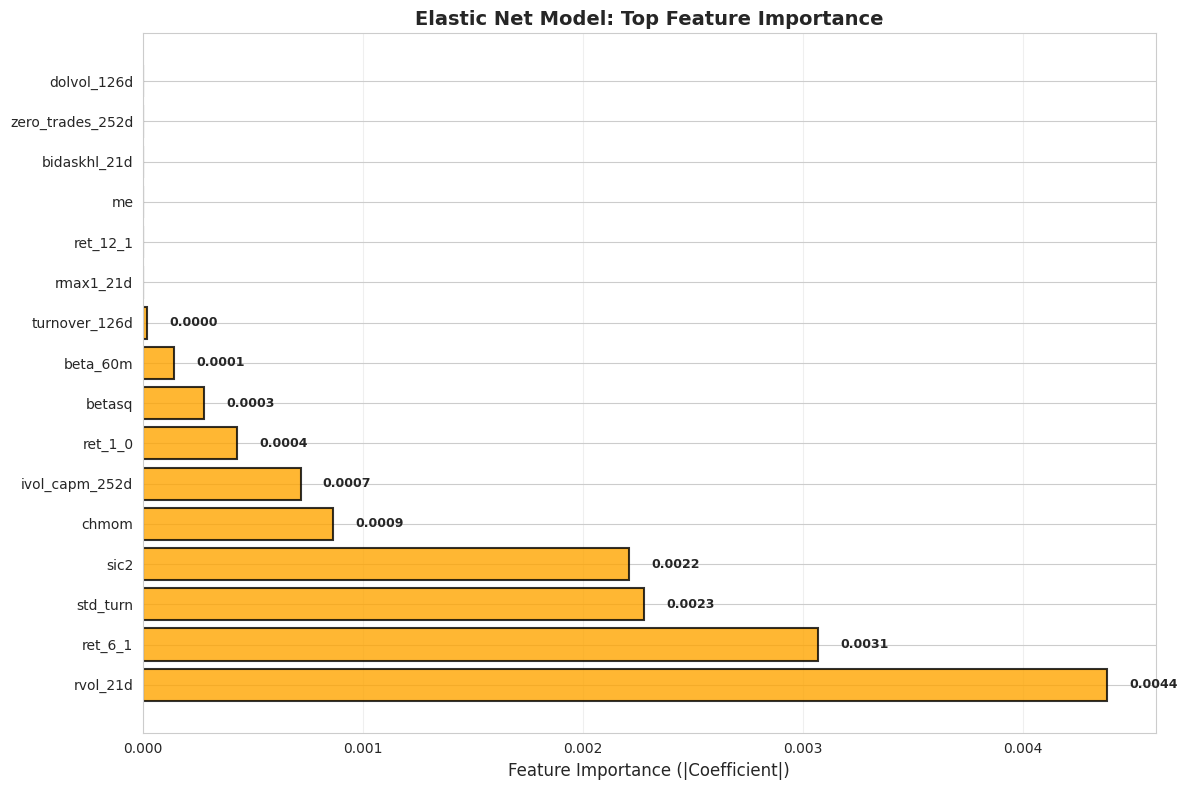

In [7]:
# Calculate feature importance (using absolute value of coefficients)
# Average coefficients across all folds, then take absolute value
coefficients_array = np.array(all_coefficients)
mean_coefficients = np.mean(coefficients_array, axis=0)
feature_importance = np.abs(mean_coefficients)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': mean_coefficients,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("=" * 70)
print("Elastic Net Model Feature Importance Analysis")
print("=" * 70)
print(f"\nTop 10 Most Important Features:")
print("-" * 70)
for i, row in feature_importance_df.head(10).iterrows():
    print(f"{row['feature']:20s}: Coefficient={row['coefficient']:8.4f}, Importance={row['importance']:8.4f}")

# Count features regularized to zero
zero_features = (feature_importance == 0).sum()
print(f"\nNumber of features regularized to zero: {zero_features}/{len(feature_names)}")

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))
top_n = min(16, len(feature_importance_df))
top_features = feature_importance_df.head(top_n)
bars = ax.barh(range(len(top_features)), top_features['importance'].values, 
               color='orange', edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Feature Importance (|Coefficient|)', fontsize=12)
ax.set_title('Elastic Net Model: Top Feature Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['importance'].values)):
    if val > 0:  # Only show non-zero values
        ax.text(val + 0.0001, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Build Portfolio and Calculate Returns


In [8]:
# Build portfolio returns
portfolio_df, summary_stats = build_portfolio_returns(
    all_actuals, 
    all_predictions, 
    all_dates, 
    all_ids, 
    n_deciles=10
)

print("\n" + "=" * 70)
print("Long-Short Portfolio Performance")
print("=" * 70)
print(f"{'Metric':<30} {'Value':<15}")
print("-" * 70)
print(f"{'Annual Return':<30} {summary_stats['annual_return']:>10.4f}")
print(f"{'Annual Volatility':<30} {summary_stats['annual_volatility']:>10.4f}")
print(f"{'Sharpe Ratio':<30} {summary_stats['sharpe_ratio']:>10.4f}")
print(f"{'Cumulative Return':<30} {summary_stats['cumulative_return']:>10.4f}")
print(f"{'N Months':<30} {summary_stats['n_months']:>10}")
print(f"{'Mean Monthly Return':<30} {summary_stats['mean_monthly_return']:>10.4f}")
print(f"{'Std Monthly Return':<30} {summary_stats['std_monthly_return']:>10.4f}")
print("=" * 70)



Long-Short Portfolio Performance
Metric                         Value          
----------------------------------------------------------------------
Annual Return                      0.6530
Annual Volatility                  0.1504
Sharpe Ratio                       4.3406
Cumulative Return                  1.9908
N Months                               21
Mean Monthly Return                0.0544
Std Monthly Return                 0.0434


## 7. Visualization Results


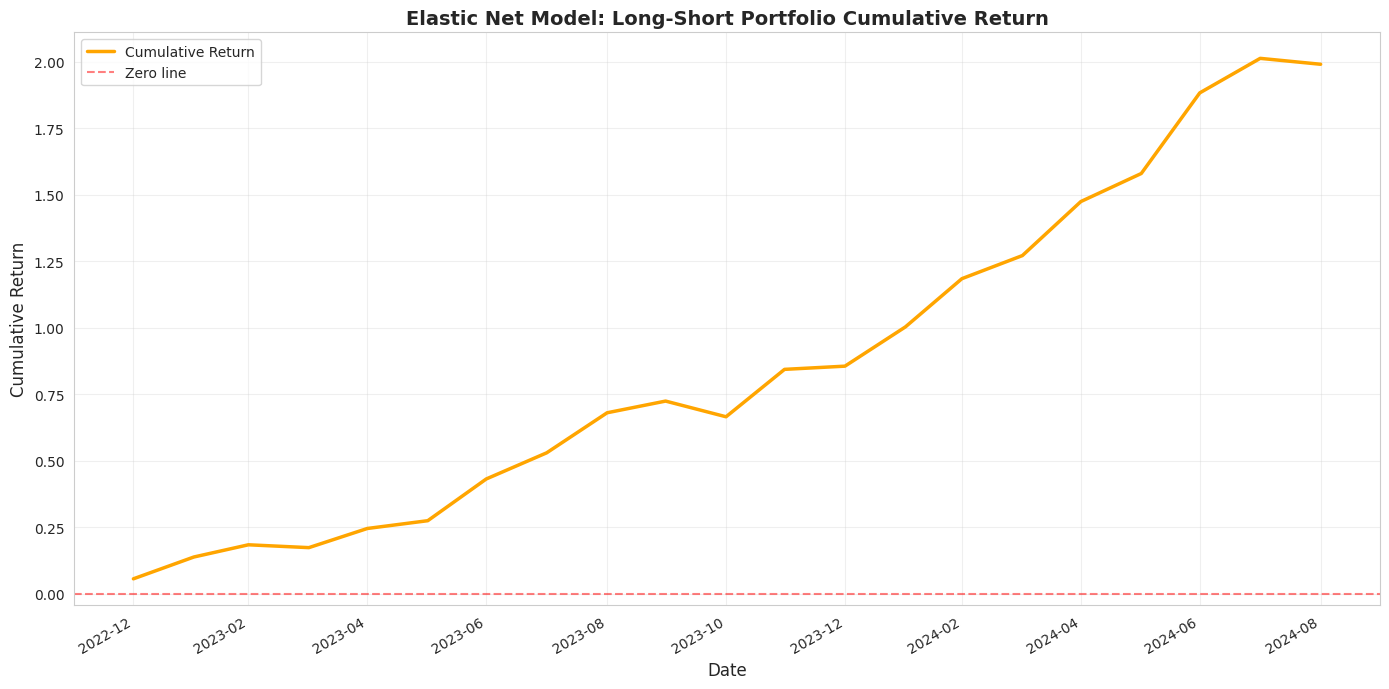

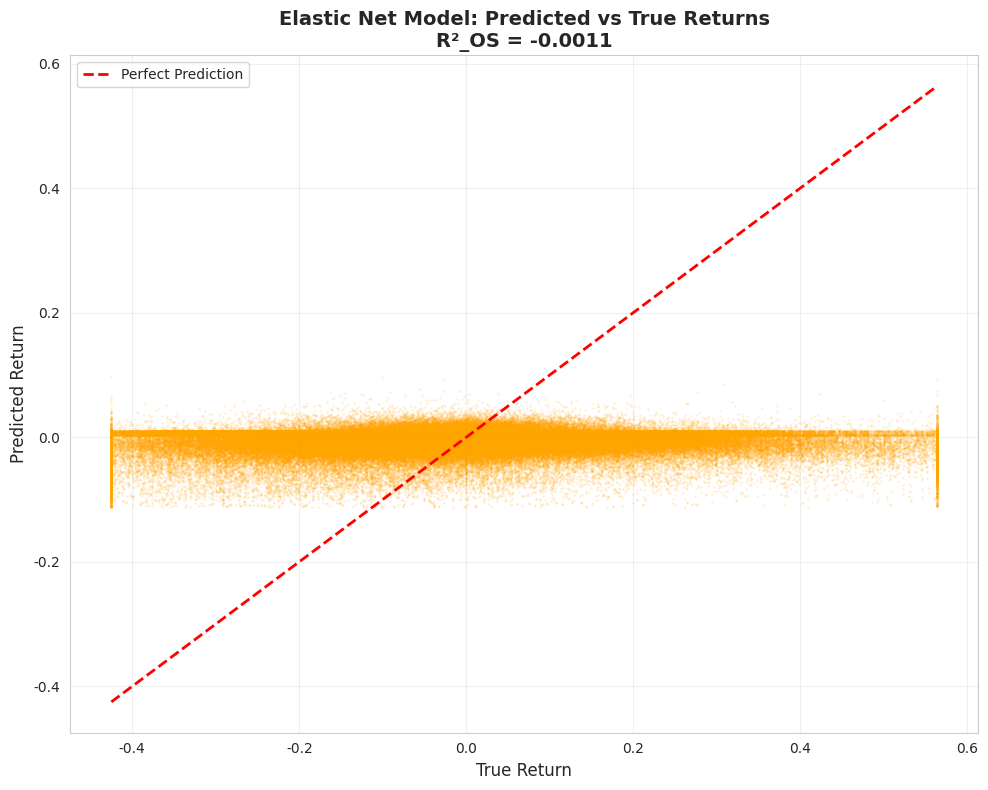

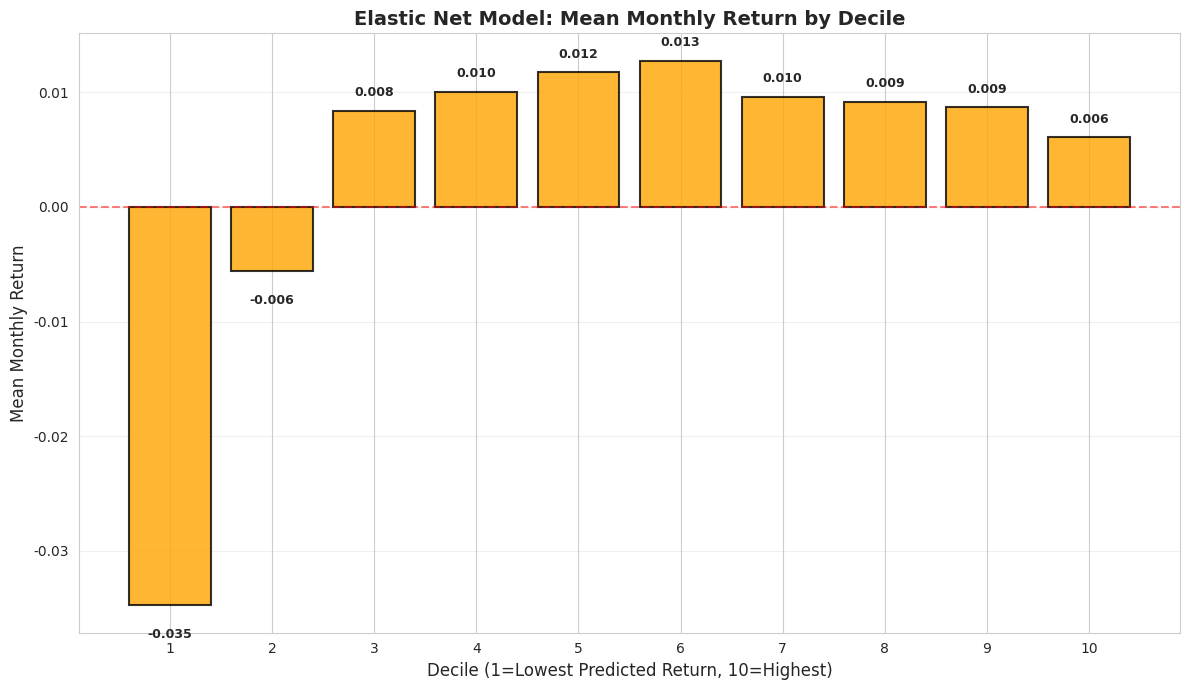

In [9]:
# Set matplotlib font
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. Cumulative return curve
if 'long_short' in portfolio_df.columns:
    portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(portfolio_df['date'], portfolio_df['cumulative_return'], linewidth=2.5, color='orange', label='Cumulative Return')
    ax.set_title('Elastic Net Model: Long-Short Portfolio Cumulative Return', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Return', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero line')
    ax.legend(fontsize=10)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

# 2. Predicted vs True Returns Scatter Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(all_actuals, all_predictions, alpha=0.1, s=1, color='orange')
ax.plot([np.min(all_actuals), np.max(all_actuals)], 
         [np.min(all_actuals), np.max(all_actuals)], 
         'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('True Return', fontsize=12)
ax.set_ylabel('Predicted Return', fontsize=12)
ax.set_title(f'Elastic Net Model: Predicted vs True Returns\nR²_OS = {metrics["r2_os"]:.4f}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Decile Portfolio Returns Comparison
if len([col for col in portfolio_df.columns if col.startswith('decile_')]) > 0:
    decile_cols = [col for col in portfolio_df.columns if col.startswith('decile_')]
    decile_means = portfolio_df[decile_cols].mean()
    
    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.bar(range(1, len(decile_means) + 1), decile_means.values, 
                   color='orange', edgecolor='black', linewidth=1.5, alpha=0.8)
    ax.set_title('Elastic Net Model: Mean Monthly Return by Decile', fontsize=14, fontweight='bold')
    ax.set_xlabel('Decile (1=Lowest Predicted Return, 10=Highest)', fontsize=12)
    ax.set_ylabel('Mean Monthly Return', fontsize=12)
    ax.set_xticks(range(1, len(decile_means) + 1))
    ax.set_xticklabels(range(1, len(decile_means) + 1))
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
    for i, (bar, val) in enumerate(zip(bars, decile_means.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.002),
                f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 8. Results Interpretation and Summary

### Model Performance Analysis

#### 1. Prediction Performance Metrics
- **R²_OS = -0.0011**: Significant improvement over OLS (-0.0234), regularization is effective
- **Correlation = 0.0426**: Nearly 2x improvement over OLS (0.0219), stronger prediction ranking ability
- **RMSE = 0.1406**: Slightly lower than OLS (0.1422)
- **MAE = 0.0910**: Slightly lower than OLS (0.0922)
- **Predicted std (0.0135) < OLS (0.0244)**: Regularization makes predictions more stable

#### 2. Hyperparameter Selection
- Most folds select **alpha=0.01, l1_ratio=0.3**, indicating moderate regularization strength works best
- The combination of L1 and L2 regularization (Elastic Net) performs better than using either alone

#### 3. Feature Importance
- **Most important features**: `rvol_21d` (volatility), `ret_6_1` (6-month momentum), `std_turn` (turnover standard deviation)
- **Feature selection**: 6/16 features are regularized to zero, indicating L1 regularization successfully performs feature selection
- Retained features are mainly related to volatility, momentum, and liquidity indicators

#### 4. Portfolio Performance
- **Annual return 65.30%**: Significant improvement over OLS (25.86%)
- **Sharpe Ratio 4.34**: Substantial improvement over OLS (1.15), excellent risk-adjusted returns
- **Annual volatility 15.04%**: Lower than OLS (22.41%), better risk control
- **Cumulative return 199.08%**: Outstanding performance

### Key Findings

1. **Regularization is effective**: Elastic Net outperforms OLS in both prediction performance and portfolio performance through L1+L2 regularization
2. **Feature selection**: L1 regularization automatically performs feature selection, improving model interpretability and prediction quality
3. **Ranking ability**: Although R²_OS is still negative, the model's ranking ability is significantly improved, reflected in excellent portfolio performance
4. **Stability**: Regularization makes predictions more stable (smaller standard deviation), reducing overfitting risk

### Conclusion

The Elastic Net model significantly improves prediction performance and portfolio performance while maintaining model simplicity by combining L1 and L2 regularization. The model successfully identifies the most important predictive features and improves generalization ability through regularization.
